In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import requests
from xml.etree import ElementTree as ET
import re
from io import StringIO
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import HTML
import numpy as np

In [3]:
HTML('''
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

# Central Insights: A Latent Semantic Analysis of Bangko Sentral ng Pilipinas Press Releases
Version date: 05 December 2023

## Executive summary
***

In this project, we explore the relevant topics based on the press releases by the Bangko Sentral ng Pilipinas (BSP) from 1999 to 2023. The raw data for the press releases is webscraped from the BSP Media and Research web page. The raw data is then cleaned and prepared and is converted into a bag-of-words design matrix using the Term Frequence-Inverse Document Frequency (TF-IDF) model for the purposes of information retrieval and keyword extraction. The TF-IDF bag-of-words then undergoes Singular Value Decomposition/Latent Semantic Analysis for dimensionality reduction. We then determine latent topics over years from the truncated singular vectors. We also determine standout topics across recent years as well as standout tokens per topic per year to demonstrate the narrative potential of the model.

## 1&emsp;Introduction
***
In the dynamic landscape of economic policymaking, central banks play a pivotal role in shaping and steering a nation's economic trajectory. They stand at the nexus of economic governance and stability, and they possess unparalleled insights into the economic pulses of their nations. Central banks are thus uniquely positioned to offer rich and comprehensive accounts about their respective nations' economic storylines. One only needs to peruse their central bank's' official publications to catch glimpses of developments in their nation's economy.

In this project, we unveil snippets of Philippine central banking history by employing Latent Semantic Analysis (LSA) on the press releases of the Bangko Sentral ng Pilipinas (BSP) as a case study. Through the lens of LSA, we aim to uncover the latent themes surrounding BSP communications, shedding light on implicit associations and connections within its press releases. We seek two answer two questions. First, what are the overarching themes in the historical narrative of Philippine central banking? Second, how have the narrative themes changed year after year?

The rest of this report proceeds as follows. Section 2 details the methodology employed to conduct the analysis. Section 3 presents the results and provides a brief discussion. Section 4 concludes.

## 2&emsp;Methodology
***

In order to conduct our analysis, we perform Latent Semantic Analysis via Singular Value Decomposition (SVD) on the corpus of BSP press releases.

First, we extract the corpus of press release data fron the BSP's website via webscraping and API extraction. We then perform data cleanup to clean the response content from the api and then parsed the XML contents into a pandas dataframe. Title and the article content are combined into a single entity and will be the input in constructing the bag of words fed into the TF-IDF vectorizer in the later step. We construct the design matrix we use for analysis by converting the press release data into a term frequency-inverse document frequency bag-of-words. Afterward, we perform dimensionality reduction on the design matrix via SVD/LSA to capture the most important features that explain the variability in the data. Finally, we apply domain knowledge to identify the latent themes from the singular values and extract practical insights. The steps are summarized in Figure 1.

Figure 1. Summary of methodology
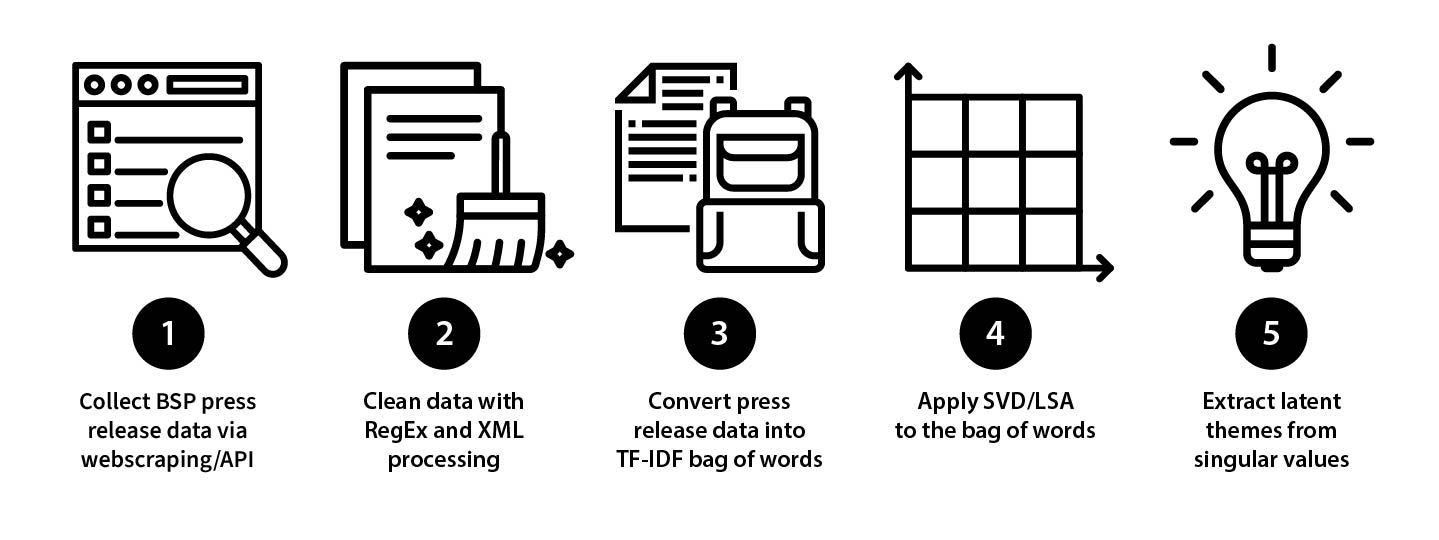

### 2.1&emsp;Data collection and cleanup

The official website of the BSP serves as the primary repository for the central bank's publication materials. Our subjects of interest, the BSP's press releases, are conveniently lodged in the "Press Releases" tab of the "Media and Research" page (BSP, n.d.). Figure 2 shows a screenshot of the subject page.

Figure 2. The BSP Media and Research webpage
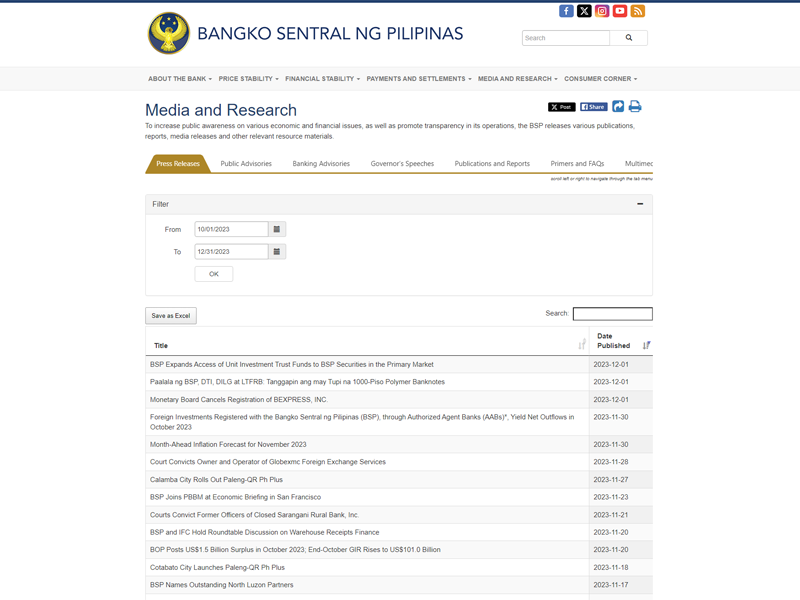

The web page displays only the 5,000 most recent press releases. As of writing, the oldest press release available for viewing via the web page dates back to April 2007. However, a deeper dive through the web page via webscraping reveals that press releases all the way from 1999 are available are obtainable via API retrieval.

**Webscraping/API helper functions:**

In [4]:
def cleancontent(data):
    """Clean content"""
    first = re.compile(r'<.*?>')
    result = first.sub('', data)
    second = re.compile(r'&#.*?;')
    result = second.sub('', result)
    return result


def cleanxml(string):
    """Clean xml"""
    it = ET.iterparse(StringIO(string))
    for _, el in it:
        _, _, el.tag = el.tag.rpartition('}')
    xml = it.root
    return xml


def load_bsp_data(year):
    """Load bsp articles for the given year"""
    url = "https://www.bsp.gov.ph/_api/web/lists/getByTitle('Media%20" + \
        "Releases%20and%20Advisories')/items?"
    filter_string = f"PDate ge '{year}-01-01T00:00:00.000Z' and " + \
        f"PDate le '{year}-11-30T00:00:00.000Z' and Tag eq 'Media" + \
        " Releases' and OData__ModerationStatus eq 0 and Status eq '2'"

    params = {
      "$select": "*",
      "$filter": filter_string,
      "$top": 5000,
      "$orderby": "PDate desc"
    }

    data = requests.get(url, params=params)
    return data


def load_bsp_data_years(start_year, end_year):
    """Load bsp articles given start and end years"""
    dict_entries = {}

    while start_year >= end_year:
        data = load_bsp_data(start_year)
        xml = cleanxml(data.text)
        entries = xml.findall('entry')
        dates = []
        titles = []
        content = []
        for each_entry in entries:
            dates.append(each_entry.findall('.//PDate')[0].text)
            titles.append(each_entry.findall('.//Title')[0].text)
            content.append(cleancontent(each_entry.findall('.//Content')[0].text))

        if 'created_date' not in dict_entries.keys():
            dict_entries['created_date'] = dates
        else:
            dict_entries['created_date'] += dates

        if 'title' not in dict_entries.keys():
            dict_entries['title'] = titles
        else:
            dict_entries['title'] += titles

        if 'content' not in dict_entries.keys():
            dict_entries['content'] = content
        else:
            dict_entries['content'] += content

        start_year -= 1
    return dict_entries

**Prepare raw dataframe via webscraping/API**

In [5]:
# Set years to extract
start = 2023
end = 1999

df = pd.DataFrame.from_dict(load_bsp_data_years(start, end))
df = df.sort_values('created_date', ascending=False)
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index(drop=True)

# Combine title and content to become a single word soup
df['title_content'] = df['title'] + " " + df['content']
df['title_content'] = df['title_content'].astype(str)
df['title_content'] = df['title_content'].str.lower()

# Remove title and content columns
df = df.drop(columns=['title', 'content'])
print("dataframe info: ")
display(df.info())
print("dataframe describe: ")
display(df.describe())
print("Webscraped dataframe:")

display(df)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   created_date   5905 non-null   object
 1   title_content  5905 non-null   object
dtypes: object(2)
memory usage: 92.4+ KB


None

dataframe describe: 


,created_date,title_content
count,5905,5905
unique,3374,5905
top,2010-09-12T16:00:00Z,foreign investments registered with the bangko...
freq,10,1


Webscraped dataframe:


,created_date,title_content
0,2023-11-29T16:00:00Z,foreign investments registered with the bangko...
1,2023-11-29T16:00:00Z,month-ahead inflation forecast for november 20...
2,2023-11-27T16:00:00Z,court convicts owner and operator of globexmc ...
3,2023-11-26T16:00:00Z,calamba city rolls out paleng-qr ph plus ​cala...
4,2023-11-22T16:00:00Z,bsp joins pbbm at economic briefing in san fra...
...,...,...
5900,1999-03-10T16:00:00Z,bsp reminds house minority block: constitutio...
5901,1999-02-18T16:00:00Z,"kbs loans up, npls down the commercial banking..."
5902,1999-02-04T16:00:00Z,rise in january inflation rate driven by suppl...
5903,1999-02-02T16:00:00Z,status of commercial banking system as of end-...


### 2.2&emsp;Convert the raw dataframe into a TF-IDF bag-of-words design matrix

We then transform the raw data of BSP press releases into a TF-IDF bag-of-words design matrix. TF-IDF is a numerical statistic used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents (corpus). The TF-IDF value for a term is calculated by multiplying its frequency (TF) in a document by the inverse document frequency (IDF) across the entire corpus. The resulting TF-IDF scores form a vector representation of the document, known as a bag-of-words, where each word is assigned a weight reflecting its significance in the context of the document and the corpus as a whole. This approach helps capture the unique characteristics of documents by emphasizing terms that are both frequent within the document and rare across the entire corpus.

We first conduct an initial transformation without setting maximum and mininum document frequency and maximum features parameters to get a preliminary sense of the data, resulting in a bag-of-words matrix with 5,905 rows corresponding to the number of documents in the corpus and 20,945 columns corresponding the the features or identified tokens. In order to preserve only the most important tokens without significantly compromising the variability in the data, we are compelled to calibrate the parameters. We find that satisfactory results are achieved by retaining only the 1,000 most important features even without setting minimum and maximum document frequency parameters.

In [6]:
# Specify a list of stop words

# If not yet downloaded
nltk.download('stopwords')
stop = list(stopwords.words('english'))
stop.extend(
    'a b c d e f g h i j k l m n o p q r s t u v w x y z www us'.split()
)
# Display stop words
# print(stop)

# Transform the initial data into a TF-IDF design matrix

vectorizer = TfidfVectorizer(
    token_pattern=r'\b([a-z]+)\b',
    max_features=1000,
    #max_df=0.95,
    #min_df=0.05,
    stop_words=stop,
    smooth_idf=True,
)
tfidf_matrix = vectorizer.fit_transform(df['title_content'])
tfidf_df = pd.DataFrame.sparse.from_spmatrix(
    tfidf_matrix,
    columns=vectorizer.get_feature_names_out(),
)
df_bow = pd.concat([df, tfidf_df], axis=1)
X = df_bow.drop(columns=['created_date', 'title_content'])
features = X.columns
print("TF-IDF bag of words df:")
display(X)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vsitu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF bag of words df:


,abroad,access,according,account,accounted,accounting,accounts,acquired,acquisition,across,...,work,workers,working,world,worth,would,year,years,yen,yielded
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.078122,0,0,0.042002
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0.059308,0,0,0,...,0,0,0.032237,0,0,0,0.014392,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5900,0,0,0,0,0,0,0,0,0,0.040062,...,0,0,0,0.08201,0,0,0,0.039423,0,0
5901,0,0,0,0,0,0,0,0.093061,0,0,...,0,0,0,0,0,0,0.035079,0,0,0
5902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5903,0,0,0,0,0.157703,0,0.14594,0.062635,0.064971,0,...,0,0,0,0,0,0,0.070831,0,0,0


### 2.3&emsp;Singular Value Decomposition and Latent Semantic Analysis

We perform SVD/LSA on the TF-IDF bag-of-words data using the `TruncatedSVD` method from the `sklearn` library (Pedregosa et al., 2011). SVD is a mathematical technique used for dimensionality reduction and feature extraction in data analysis. In the context of natural language processing, SVD is often applied to term-document matrices in techniques like LSA. LSA utilizes SVD to transform the original high-dimensional space of terms and documents into a lower-dimensional space, capturing the latent semantic structure in the data. This process helps uncover underlying patterns and relationships between words and documents, allowing for more efficient information retrieval and text analysis in applications such as document clustering and topic modeling.

We set the number of components to 100 as prescribed by the documentation of the `TruncatedSVD` method. We explain the statistical diagnostic outputs resulting from this choice in Section 3.1.

In [7]:
# Set number of singular values
k = 100

# Decompose
svd = TruncatedSVD(
    n_components=k,
)
X_reduced = svd.fit_transform(X.to_numpy())
Sigma = svd.singular_values_
V_T = svd.components_.T

### 2.4&emsp;Identification of latent themes

Our final step is to extract value from the model by identifying the latent themes embedded within the corpus of BSP's press releases. First, we identify the latent concepts prevalent across the entire corpus of BSP's press releases. We then focus on the latent themes per year by applying the methodology on subsets of the data specified by year starting from 2013. We also show how zooming in on how the tokens within a recurring latent concept change represents a shift in the narrative regarding that specific theme. We discuss the results in Section 3.

## 3&emsp;Results and discussion
***

In this section we present the results of our model. First, we present the latent concepts identified using the corpus of press releases from 1999 to 2023 to capture an overall idea of what the BSP talks about in its press releases. Second, we use year-specific subsets of the corpus to see what themes stand out every year, allowing us to determine changes in BSP's communication priorities over time. Finally, as a demonstration of the value of our model, we zoom in on a specific latent concept recurring over time and examine how the tokens within the latent concept change over time.

### 3.1&emsp;Preliminaries

Figure 3 shows the scatter plot of the reduced TF-IDF matrix across the first two singular vectors.

<center>Figure 3. Scatter plot of reduced TF-IDF matrix across first two singular vectors</center>

<center><img src="images/scatterplotsv.png" alt="scatterplotsv.png"/></center><br><center>

Taking the top 100 singular values yields a cumulative variance explained of 66.57 percent, which we accept as satisfactory being that more than half of the variance of the truncated data (retaining 1,000 features) is explained.

<center>Figure 4. Cumulative variance explained at 100 singular values</center>

<center><img src="images/cumvarexplained.png" alt="cumvarexplained.png"/></center><br><center>

In [8]:
# HIDDEN CELL TO DEVELOP SCATTERPLOT

#plt.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=0.5)
#plt.title('Scatter Plot of Reduced TF-IDF Matrix')
#plt.xlabel('SV 1')
#plt.ylabel('SV 2')
#plt.tight_layout()
#plt.savefig('scatterplotsv.png')
#plt.show()

In [9]:
# HIDDEN CELL TO DEVELOP CUMULATIVE VARIANCE EXPLAINED

#print(f"Cumulative variance explained at {k} retained singular values: {(svd.explained_variance_ratio_*100).cumsum()[-1]:.2f}%")

#plt.plot((svd.explained_variance_ratio_*100).cumsum())
#plt.title('Smoothed Cumulative Variance Explained by Truncated SVD')
#plt.xlabel('Number of Singular Values')
#plt.ylabel('Cumulative Variance Explained')
#plt.tight_layout()
#plt.savefig('cumvarexplained.png')
#plt.show()

### 3.2&emsp;Top 10 latent themes identified

As a demonstration of the analytical potential of LSA, we examine the top 10 groups of words and see if we can discern their respective topics from a human standpoint. (The top 10 singular vectors account for 30.67 percent of cumulative variance.) Because the LSA is an unsupervised learning technique, we do not expect all of the 100 latent concepts identified through the mathematical underpinnings of the model to be human-interpretable (Ioana, 2020). We may also find some overlaps in the latent themes identified by the model, especially at lower singular values. Again, we accept these limitations as given knowing that the BSP deals with very specific aspects of economic governance, and there is only so much that it can talk about in its press releases given the clearly defined scope under which it operates.

In [10]:
# HIDDEN CELL TO DEVELOP SV CHARTS

#feature_names = vectorizer.get_feature_names_out()
#for i in range(20):
#    fig, ax = plt.subplots()
#    order = np.argsort(np.abs(svd.components_.T[:, i]))[-20:]
#    ax.barh([feature_names[o] for o in order], svd.components_.T[order, i])
#    ax.set_title(f'SV{i+1}')
#    fig.tight_layout()
#    plt.savefig(f'sv{i+1}_final.png')

In [11]:
# HIDDEN CELL TO DEVELOP LATENT THEME CLUSTERS, POSITIVE ASSOCIATIONS

#for i, comp in enumerate(svd.components_[:20]):
#    terms_comp = zip(features, comp)
#    sorted_terms = sorted(
#        terms_comp, key=lambda x: x[1], reverse=True
#    )[:10]
#    print("Topic "+str(i+1)+": ")
#    soup = [i[0] for i in sorted_terms]
#    print(soup)

The first latent concept (Figure 5) consists of a hodgepodge of frequently used words by the central bank in its core press releases. Besides this, there does not seem to be a specific underlying concept that unifies the words in this cluster. We thus interpret this cluster as the mother topic of all BSP press releases: central banking.

<center>Figure 5. Central banking latent concept</center>

<center><img src="images/sv1_final.png" alt="sv1_final.png" style="width:800px; height:600px"/></center>

The second latent concept (Figure 6) is about inflation. The concept seems to cover the sources of inflation (as indicated by the presence of the terms *food* and *pressures*) as well as the Monetary Board's policy response to inflation via adjustments of the policy rate.

<center>Figure 6. Inflation latent concept</center>

<center><img src="images/sv2_final.png" alt="sv2_final.png" style="width:800px; height:600px"/></center>

The third latent concept (Figure 7) is about the key performance indicators of the banking sector. The most important terms *percent* and *ratio* strongly support the notion that this cluster of words are about numerical indicators. The terms *npl* and *npls* (non-performing loan/s), *tlp* (total loan provision), *loans*, and *npa* (non-performing asset) are all banking sector performance metrics.


<center>Figure 7. Banking sector key performance indicators latent concept</center>

<center><img src="images/sv3_final.png" alt="sv3_final.png" style="width:800px; height:600px"/></center>

We find our first overlap in the fourth and ninth latent concepts (Figure 8). They are about the BSP's annual awards and appreciation ceremony for outstanding regional stakeholders, with the ninth latent concept seemingly having a stronger association with the identified theme than the fourth. The BSP has been recognizing significant stakeholders and partner institutions from each region in the Philippines since 2007 and publishes a few press releases about these ceremonies annually.

<center>Figure 8. Recognition of regional stakeholders latent concept</center>

<center><img src="images/sv4_final.png" alt="sv4_final.png" style="width:800px; height:600px"/> <img src="images/sv9_final.png" alt="sv9_final.png" style="width:800px; height:600px"/></center>

The fifth and sixth latent concepts (Figure 9) are also seemingly overlapping topics that refer to the BSP's rediscount facility, a standing credit facility used to help banks with their liqudity needs. The rediscount facility is one of the BSP's monetary tools to influence the level of credit in the financial system. There are two categories of rediscount facilities: the "Peso Rediscount Facility" and the "Exporters Dollar and Yen Rediscount Facility".

<center>Figure 9. Rediscount facility latent concept</center>

<center><img src="images/sv5_final.png" alt="sv5_final.png" style="width:800px; height:600px"/> <img src="images/sv6_final.png" alt="sv6_final.png" style="width:800px; height:600px"/></center>

The seventh latent concept (Figure 10) is very clearly about the remittances of overseas Filipino workers, deemed to be a key driver of growth and consumption in the Philippine economy. The BSP regularly reports the level of remittance inflows in a disaggregated manner (cash and personal remittances).

<center>Figure 10. Remittances latent concept</center>

<center><img src="images/sv7_final.png" alt="sv7_final.png" style="width:800px; height:600px"/></center>

The eight latent concept (Figure 11) is about the growth of domestic liquidity. Domestic liquidity is determined in part by the level of bank lending (or loans and credit) in the financial system and the level of net foreign assets (nfa) by the BSP and domestic banks.

<center>Figure 11. Domestic liquidity latent concept</center>

<center><img src="images/sv8_final.png" alt="sv8_final.png" style="width:800px; height:600px"/></center>

The tenth latent concept (Figure 12) is about market expectations. Market expectations are significant inputs to BSP policymaking. Every quarter, the BSP conducts surveys among households and firms to capture their expectations of the economy moving forward.

<center>Figure 12. Market expectations latent concept</center>

<center><img src="images/sv10_final.png" alt="sv10_final.png" style="width:800px; height:600px"/></center>

### 3.3&emsp;Identifying standout concepts per year: A demonstration from 2013 to 2023 press releases

We extract further practical value from this exercise by identifying the latent concepts that stand out per year. Doing so allows us to determine what economic and policy priorities had formed during specific years, narrating a timeline of central banking developments. As a demonstration, we perform this exercise on year-specific subsets of the corpus of press releases from 2013 to 2023. The results of this exercise are as follows.

In 2013 and 2015, latent topics referring to the implementation of regulatory reliefs on banks appeared. This indicates that the BSP implemented regulatory relief measures for banks for some reason. Examining the press releases from these periods reveals that these measures were implemented to provide relief for banks because of the adverse effects of typhoons on the Philippine banking system.

In 2017, topics referring to the ASEAN Banking Integration Framework and the phaseout of old generation banknotes stood out. It was during this time that the BSP's negotiations with ASEAN central banks regarding regional banking integration were being concluded. The full transition from the old to the new generation of banknotes was also taking place in 2017.

In 2018, the Financial Stability Coordination Council (FSCC) stood out as a latent concept, signifying a strengthening of the BSP's commitment to preserving financial stability in the Philippine financial system.

In 2019, themes on the release of new coins and reductions in reserve requirements for banks surfaced. The BSP released its new 20-Piso coins and enhanced 5-Piso coins into circulation in 2019. During this time, the Monetary Board also slashed the reserve requirement ratio for banks a few times, signifying the central bank's move toward a more expansionary monetary policy.

In 2020, latent concepts referring to inflation outlooks and financial stability became prominent. It is worth noting that the BSP started releasing month-ahead inflation outlooks only in the latter half of 2018 and likely doubled down on the effort in 2020. Moreover, the BSP became more vocal about financial stability as the FSCC was institutionalized by an Executive Order by then-President Rodrigo R. Duterte during the year.

In 2021, digitalization and, more specifically, digitalization were the standout themes of the year. The push towards digitalization was the BSP's response to the ongoing coronavirus-2019 pandemic.

In 2022, topics referring to the release of the new polymer 1,000-Piso banknote and, once again, digital payments were standout topics. It was during this year that the BSP issued the Philippines' first polymer banknote into circulation. The topic of digital payments was also a continuing concern for the BSP, indicating the central bank's clear commitment toward making digital payments more prevalent in the country.

Finally, in 2023, the BSP's Paleng-QR initiative, convictions against violators of the BSP's Manual of Regulations for Non-Bank Financial Institutions (MORNBFI), and Islamic banking were the new standout topics for the year. The Paleng-QR PH initiative is in line with the BSP's thrust to promote digital payments in the country, specifically in wet markets. The BSP also ramped up its efforts to pursue violators of the MORNBFI during the year. Islamic banking also became a top concern of the BSP in 2023.

### 3.4&emsp;Identifying standout tokens per concept per year: A case of a shift in the inflation narrative

We show some further value of our model by identifying tokens that stand out in certain latent concepts per year. We take the case of the latent concept of inflation to demonstrate.

In the cluster of tokens referring to inflation, the term *supply* appeared for the first time among the top positive-association tokens when using the subset data for 2021 (Figure 13) and once again using the data for 2022 (Figure 14). This represents a material change in the inflation narrative of the BSP during these years. It should be noted that the Philippines' most recent inflationary episode (of which the height was felt in 2022) was driven mostly by supply-side factors beyond the BSP's realm of policy influence. Based on the appearance of the *supply* token in the latent theme referring to inflation, it seems that the BSP was keen on informing the public about this information.

<center>Figure 13. Inflation latent concept (positive association tokens), 2021</center>

<center><img src="images/svinf2021.png" alt="svinf2021.png" style="width:800px; height:600px"/></center><center>
    
<center>Figure 14. Inflation latent concept (positive association tokens), 2022</center>

<center><img src="images/svinf2022.png" alt="svinf2022.png" style="width:800px; height:600px"/></center><center>

One may apply the same line of thinking to other latent concepts non-varying over time to see how the narrative with respect to those themes change.

## 4&emsp;Conclusion
***

In this report, we showed how LSA can be used to tell the a story of central banking history using the BSP's press releases as a case study. We determined the overarching themes of concern in BSP communications as well as standout concepts per year to demonstrate the potential of LSA to uncover changing narratives and policy priorities of the BSP. We also showed how focusing on standout tokens within recurring themes per year represents shifts in the narrative for those themes using inflation as an example theme. ALl in all, we showed how the mathematical underpinnings of SVD and LSA can be used to interpret historical text data to tell a story of dynamism in BSP policymaking.

This work can be applied practically by creating a search-by-similarity information retrieval system for BSP press releases, effectively creating a press release recommender system for those viewing the press release materials via the BSP website. As of writing, the BSP does not have a recommender system for its press releases. It would be helpful to link viewers reading any single press release to similar articles in the BSP's repository. However, even without this, policymakers, researchers, and enthusiasts will find value in knowing about the timeline of BSP's policy communication priorities as they will be provided a good starting point from which to begin a search.

Our work can be improved by applying a more quantitative approach in determining how common the singular values are per year. In this exercise, we relied on domain knowledge to decide if the seemingly common singular values we derived each year did, indeed, refer to the same latent concepts. For future work, we could derive similarity measures such as cosine similarity to judge if these latent concepts per year truly are similar enough to conclude that they refer to the same thing.

## References
***

Bangko Sentral ng Pilipinas. (n.d.). Media and Research. Bangko Sentral ng Pilipinas. https://www.bsp.gov.ph/SitePages/MediaAndResearch/MediaList.aspx?TabId=1/

Ioana. (2020). Latent Semantic Analysis: intuition, math, implementation. Medium.com. https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8/

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., &amp; Duchesnay, É. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12(85), 2825–2830. https://jmlr.csail.mit.edu/